# Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis that seeks to build a hierarchy of clusters (not just partition of the sample into disjoint sets, but a system of nested partitions).

There are two stategies for hierachy clustering:
* Divisive or top-down algorithms split the sample into smaller and smaller clusters
* Agglomerative or bottom-up algorithms, in which objects are combined into larger and larger clusters
 

<img src="assets/aglo_and_divisive.jpeg" width="600" height="300">


The agglomerative approach is more popular and effective. The algorithm itself looks pretty simple and consists of the following steps:
* Create as many clusters as there are objects, each object in its own separate cluster.
* Iteratively repeat the merging of the two closest clusters until the stopping criterion is met.

## Linkage and Distance

At first, each object is considered as one cluster. For single element clusters, the distance function is naturally defined:

$
R(\{\boldsymbol x\},\{\boldsymbol y\})=\rho (\boldsymbol x, \boldsymbol y)
$

The distances between objects $\rho$ can be specified by any metric, both Euclidean and Manhattan distance or, for example, the cosine measure.
Then the process of clusters merging starts. At each iteration, instead of the pair of closest clusters $U$ and $V$, a new cluster $W = U \cup V$ is formed. There are several methods of identifing closest clusters:

* Single linkage aka Nearest Point Algorithm:
  
$
\hspace{2mm} R_{min}(U, V)=\min\limits_{u \in U, v \in V}\rho (u, v)
$
* Complete linkage aka Farthest Point Algorithm: 

$
\hspace{2mm} R_{max}(U, V)=\max\limits_{u \in U, v \in V}\rho (u, v)
$
* Unweighted Pair Group Method with Arithmetic mean (UPGMA): 

$
\hspace{2mm} R_{avg}(U, V)=\dfrac{1}{|U|\cdot|V|}\sum\limits_{u \in U}\sum\limits_{v \in V}\rho (u, v)
$
* Unweighted Pair Group Method with Centroid average (UPGMC): 

$
\hspace{2mm} R_{cen}(U, V)=\rho^2(\sum\limits_{u \in U}\dfrac{u}{|U|}, \sum\limits_{v \in V}\dfrac{v}{|V|})
$
* Ward's method: 

$
\hspace{2mm} R_{ward}(U, V)=\dfrac{|U|\cdot|V|}{|U|+|V|}\rho^2(\sum\limits_{u \in U}\dfrac{u}{|U|}, \sum\limits_{v \in V}\dfrac{v}{|V|})
$


At each step, it is good to be able to quickly calculate the distance from the formed cluster $W = U \cup V$ to any other cluster $S$, using known distances from previous steps. This is easily accomplished using the equation proposed by Lance and Williams in 1967:


$
R(W,S)=\alpha_{U}\cdot R(U,S)+\alpha_{V}\cdot R(V,S)+\beta\cdot R(U,V)+\gamma\cdot|R(U,S)−R(V,S)|
$

$\alpha_{U}, \alpha_{V}, \beta, \gamma - $ some parameters


For each of the above distance functions, compliance with the Lance-Williams equation has been proven for certain combinations of parameters
* Single linkage: $\alpha_{U}=0.5, \alpha_{V}=0.5, \beta=0, \gamma=-0.5$

* Complete linkage: $\alpha_{U}=0.5, \alpha_{V}=0.5, \beta=0, \gamma=0.5$
* UPGMA: $\alpha_{U}=\dfrac{|U|}{|W|}, \alpha_{V}=\dfrac{|V|}{|W|}, \beta=0, \gamma=0$
* UPGMC: $\alpha_{U}=\dfrac{|U|}{|W|}, \alpha_{V}=\dfrac{|V|}{|W|}, \beta=-\alpha_{U}\cdot \alpha_{V}, \gamma=0$
* Ward's method: $\alpha_{U}=\dfrac{|S|+|U|}{|S|+|W|}, \alpha_{V}=\dfrac{|S|+|V|}{|S|+|W|}, \beta=\dfrac{-|S|}{|S|+|W|}, \gamma=0$

In [2]:
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering

def predict_clusters(X, n_clusters=2, linkage='ward'):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    clusters = agg_clustering.fit_predict(X)
    return clusters

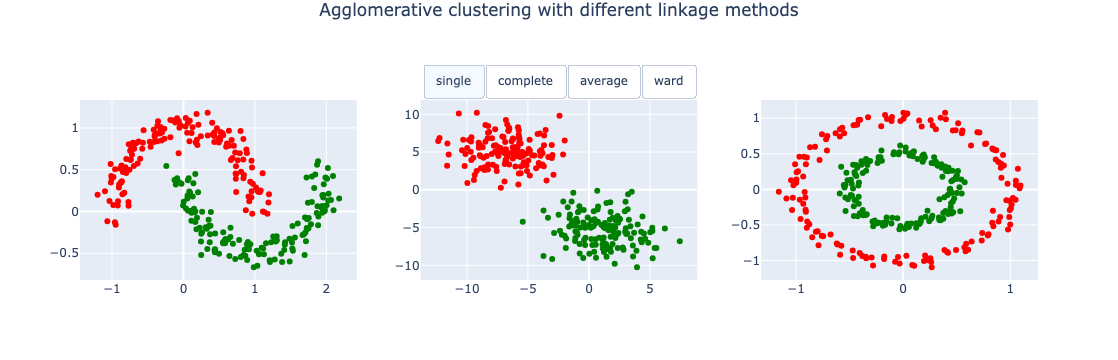

In [4]:
from sklearn.datasets import make_blobs, make_moons, make_circles

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=47)
X_blobs, y_blobs = make_blobs(n_samples=300, centers=2, cluster_std=2.0, random_state=107)
X_circs, y_circs = make_circles(n_samples=300, noise=0.05, random_state=47, factor=0.5)


fig = make_subplots(rows=1, cols=3)
linkage_methods = ['single', 'complete', 'average', 'ward']

def cluster2color(clusters):
    return ['red' if i == 0 else  'green' for i in clusters]

for linkage_method in linkage_methods:
    
    fig.add_trace(
        go.Scatter(
            x=X_moons[:, 0], 
            y=X_moons[:, 1], 
            mode='markers', 
            marker=dict(color=cluster2color(predict_clusters(X_moons, linkage=linkage_method))),
            visible=False
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=X_blobs[:, 0], 
            y=X_blobs[:, 1], 
            mode='markers', 
            marker=dict(color=cluster2color(predict_clusters(X_blobs, linkage=linkage_method))),
            visible=False
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Scatter(
            x=X_circs[:, 0], 
            y=X_circs[:, 1], 
            mode='markers', 
            marker=dict(color=cluster2color(predict_clusters(X_circs, linkage=linkage_method))),
            visible=False
        ),
        row=1, col=3
    )

for i in range(3):
    fig.data[i].visible = True

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            showactive=True,
            x=0.5,
            xanchor="center",
            y=1.2,
            yanchor="top",
            buttons=list([
                dict(label=linkage_method,
                     method="update",
                     args=[{"visible": [False] * i * 3 + [True] * 3  + [False] * 3 * (4 - i)}])
                for i, linkage_method in enumerate(linkage_methods)
            ]),
        )
    ]
)

fig.update_layout(
    title={"text": "Agglomerative clustering with different linkage methods", "x": 0.5, "y": 0.99},
    showlegend=False,
)

fig.show()

## Dendrogram
As clusters merge, each iteration of the algorithm corresponds to a pair of clusters merged at this iteration, as well as the distance between the clusters at the moment of merging. Distances will only increase with iteration, so it becomes possible to visualize the result in the form of a beautiful cluster tree called a <b>dendrogram</b>.

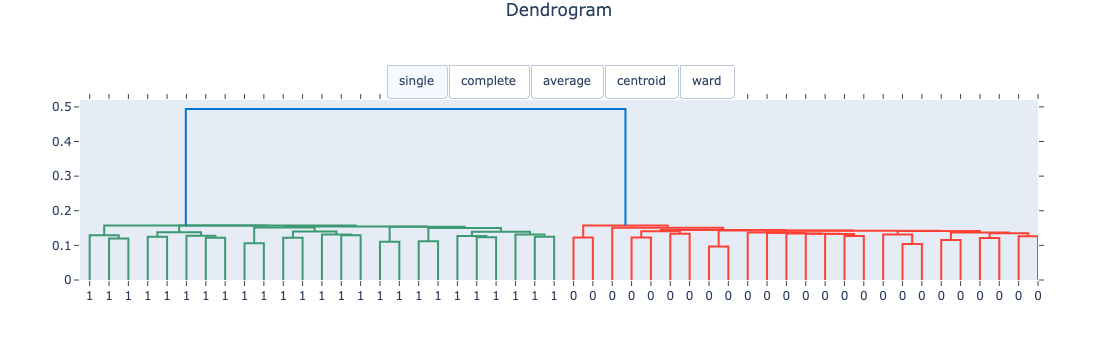

In [5]:
import plotly.figure_factory as ff
import plotly.graph_objects as go

X, y = make_moons(n_samples=50, noise=0.01, random_state=47)

fig = go.Figure()
trace_cnt = []
layouts = []

linkage_methods = ['single', 'complete', 'average', 'centroid', 'ward']
num_clusters = 2

for linkage_method in linkage_methods:

    dendrogram = ff.create_dendrogram(
        X, labels=y,
        linkagefun=lambda x: linkage(x, method=linkage_method)
    )

    trace_cnt.append(len(dendrogram.data))
    
    for data in dendrogram.data:
        data.visible = False
        data.showlegend = False
        fig.add_trace(data)

    layouts.append(dendrogram.layout)

fig.update_layout(
    title={"text": "Dendrogram", "x": 0.5, "y": 0.99},
    xaxis=layouts[0]["xaxis"],
    yaxis=layouts[0]["yaxis"],
)

for i in range(trace_cnt[0]):
    fig.data[i].visible = True

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            showactive=True,
            x=0.5,
            xanchor="center",
            y=1.2,
            yanchor="top",
            buttons=list([
                dict(label=linkage_method,
                     method="update",
                     args=[
                         {"visible": [False] * sum(trace_cnt[:i]) + [True] * trace_cnt[i]  + [False] * sum(trace_cnt[i:])},
                         {
                             "xaxis": layouts[i]["xaxis"], 
                             "yaxis": layouts[i]["yaxis"],
                             "autosize": False,
                         }
                     ]
                    )
                for i, linkage_method in enumerate(linkage_methods)
            ]),
        )
    ])

fig.show()

## Number of clusters

To determine the number of clusters, the interval of maximum length $|R_{t+1}−R_{t}|$ is found. The final clusters are the clusters obtained at step $t$. In this case, the number of clusters is equal to $m−t+1$. However, when the number of clusters is unknown in advance and there are not very many objects in the sample, it can be useful to look at full dendrogram.

## Pros and Cons

There is no exact answer to the question of which linkage algorithm is better. Each of the distances listed above has its own disadvantages and is not suitable for all tasks.

* The single linkage method has a chain effect when, regardless of the shape of the cluster, objects closest to the boundary are added to it. The nearest neighbor method is well suited for identifying ribbon-shaped clusters (like moons).

* The complete linkage method does not have a chain effect, but at an early stage it can unite rather dissimilar groups.

* The UPGMC quite intuitive and seems to be the “golden mean”.

* Ward's method turned out to be the best according to the results of experimental comparison on a representative set of model problems. It recovers the intuitively best clustering more often than other methods.

## Iris Dataset

Let's test Ward's method on some real dataset.

In [44]:
import plotly.express as px

df = px.data.iris()
X = df[["sepal_length", "sepal_width", "petal_width"]]

clusters = predict_clusters(X, n_clusters=3)

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'surface'}, {'type': 'surface'}]])

fig.add_trace(
    go.Scatter3d(
        x=df["sepal_length"],
        y=df["sepal_width"],
        z=df["petal_width"],
        mode='markers',
        marker=dict(
            color=df["species_id"]
        )
    ),
    row=1, col=1,
)

fig.add_trace(
    go.Scatter3d(
        x=df["sepal_length"],
        y=df["sepal_width"],
        z=df["petal_width"],
        mode='markers',
        marker=dict(
            color=clusters
        )
    ),
    row=1, col=2
)

fig.update_traces(marker_size = 5, showlegend=False)

fig.update_layout(scene={'domain': {'x': [0.0, 0.5], 'y': [0.0, 1.0]},
              'xaxis': {'title': {'text': 'sepal_length'}},
              'yaxis': {'title': {'text': 'sepal_width'}},
              'zaxis': {'title': {'text': 'petal_width'}}})
fig.show()

On the plot above you can see result of clustering (right plot). You can see it pretty similar with ground truth (left plot).